In [5]:
import sys
sys.path.append("..")

In [3]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.inspection import partial_dependence

In [4]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
BASEPATH = 'C:/Users/Surya/SuryaMain/PythonProjects/Chinook-Growth-Project'
#BASEPATH = '/Users/johnbuckner/github/Chinook-Growth-Project'
SIMULATION_BASEPATH = os.path.join(BASEPATH, "simulate_nonlinear_data")

In [31]:
class RFRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, params):
        self.hparams = params
        self.rfr = RandomForestRegressor(**self.hparams)

    def fit(self, X_train, y_train):
        self.rfr.fit(X_train,y_train) 
        self.feature_importances_ = self.rfr.feature_importances_
        self

    def predict(self, X):
        pred = self.rfr.predict(X)
        return pred

In [39]:
def train_sim_model(params = {"n_estimators": 20, "oob_score":True, "min_impurity_decrease":0.1}, data_path = os.path.join(SIMULATION_BASEPATH, 'data_set_1')):
    X = pd.read_csv(os.path.join(data_path, 'X.csv')).drop(['Unnamed: 0'], axis=1)
    y = pd.read_csv(os.path.join(data_path, 'y.csv')).drop(['Unnamed: 0'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=12)
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    rf_model = RFRegressor(params = params)
    rf_model.fit(X_train,y_train.ravel())
    r2_train = rf_model.score(X_train, y_train)
    test_pred = rf_model.predict(X_test, y_test)
    r2_test = rf_model.score(X_test, y_test)
    return [rf_model, (r2_train, r2_test)]

def sim_dataframe(simulation_datapath = SIMULATION_BASEPATH):
    features = []
    r2_train_vals = []
    r2_test_vals = []
    total_effects = []
    nonlinear_vals = []
    interactions_vals = []
    rhoX_vals = []
    intX_vals = []
    rhoU_vals = []
    intU_vals = []
    n = []
    cos_sims = []
    cos_sims_rand = []

    for data_path in os.listdir(simulation_datapath):
        if "data_set_" in data_path:
            full_datapath = os.path.join(SIMULATION_BASEPATH,data_path)
            rf_model, (r2_train, r2_test) = train_sim_model(data_path = full_datapath)
            cos_sim, cos_sim_rand = compare_vi(rf_model, os.path.join(full_datapath, 'Imp.csv'))
            hyperparams = pd.read_csv(os.path.join(full_datapath, 'hyper_params.csv'))
            features.append(hyperparams['m'][0])
            r2_train_vals.append(r2_train)
            r2_test_vals.append(r2_test)
            total_effects.append(hyperparams['total_effect'][0])
            nonlinear_vals.append(hyperparams['nonlinear'][0])
            interactions_vals.append(hyperparams['interactions'][0])
            rhoX_vals.append(hyperparams['rho_X'][0])
            intX_vals.append(hyperparams['int_X'][0])
            rhoU_vals.append(hyperparams['rho_U'][0])
            intU_vals.append(hyperparams['int_U'][0])
            n.append(hyperparams['n'][0])
            cos_sims.append(cos_sim)
            cos_sims_rand.append(cos_sim_rand)

    df = pd.DataFrame({
        'features': features,
        'r2_train': r2_train_vals,
        'r2_test': r2_test_vals,
        'totals_effect': total_effects,
        'nonlinear': nonlinear_vals,
        'interactions': interactions_vals,
        'rho_X': rhoX_vals,
        'int_X': intX_vals,
        'rho_U': rhoU_vals,
        'int_U': intU_vals,
        'N': n,
        'cos_sim': cos_sims,
        'cos_sim_rand':cos_sims_rand

    })

    return df

def compare_vi(model, path):
    imp = np.array(pd.read_csv(path)['Imp'])
    
    imp_rand = np.array(pd.read_csv(path)['rand'])
    imp_rf = model.feature_importances_
    
    cos_sim = np.inner(imp, imp_rf) / (np.linalg.norm(imp_rf) * np.linalg.norm(imp))
    cos_sim_rand =  np.inner(imp_rand, imp_rf) / (np.linalg.norm(imp_rf) * np.linalg.norm(imp_rand))
    
    return [cos_sim, cos_sim_rand]

In [ ]:
data_1_df = sim_dataframe()

In [ ]:
data_1_df.to_csv("/Users/johnbuckner/github/Chinook-Growth-Project/main/sim_results_4.csv")

# R Squared Boxplots

In [ ]:
def fig_boxplot_r2differences(df, xvar, title='', show_outliers=False):
    r2_differences_all = {}
    stats_all = {}
    for val in df[xvar].unique():
        r2_differences = np.array(df.loc[df[xvar] == val]['r2_train'] - df.loc[df[xvar] == val]['r2_test'])
        q1 = np.quantile(r2_differences, 0.25)
        q3 = np.quantile(r2_differences, 0.75)
        med = np.median(r2_differences)
        upper_bound = q3 + (1.5*(q3-q1))
        lower_bound = q1 - (1.5*(q3-q1))

        r2_differences_all[f'{xvar}_{str(val)}'] = r2_differences
        outliers = sorted(r2_differences[(r2_differences <= lower_bound) | (upper_bound <= r2_differences)])
        stats_all[f'{xvar}_{str(val)}'] = {'outliers': outliers, 'median':med, 'IQR':q3-q1}

    fig = plt.figure()
    axes = fig.add_axes([0,0,1,1])
    plt.boxplot(r2_differences_all.values(), showfliers=show_outliers)
    k = len(df[xvar].unique())
    plt.xticks([i for i in range(1,k+1)],sorted(list(df[xvar].unique())))
    plt.grid()

    plt.xlabel(title)
    plt.ylabel("Train r^2 - Test r^2 (Decimal 0.0-1.0)")
    
    return [fig, stats_all]


In [ ]:
fig_bxplt_features, stats_features= fig_boxplot_r2differences(data_1_df, 'features', title='Number of Features')
fig_bxplt_nonlinear, stats_nonlinear = fig_boxplot_r2differences(data_1_df, 'nonlinear', title='Number of Nonlinear features')

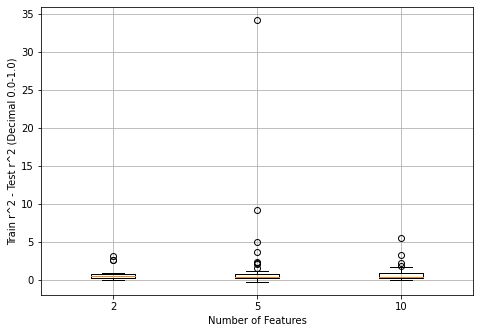

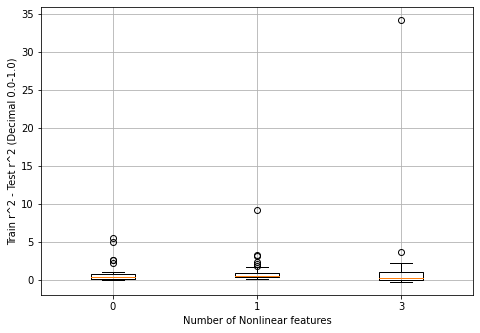

In [27]:
fig_bxplt_features, stats_features= fig_boxplot_r2differences(data_1_df, 'features', title='Number of Features', show_outliers=True)
fig_bxplt_nonlinear, stats_nonlinear = fig_boxplot_r2differences(data_1_df, 'nonlinear', title='Number of Nonlinear features', show_outliers=True)

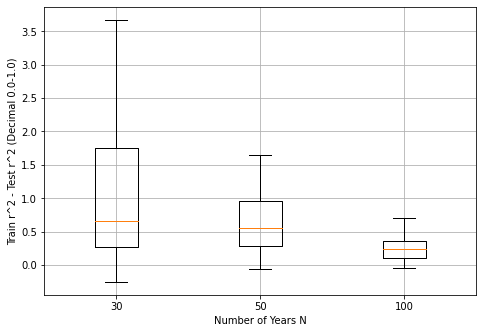

In [28]:
fig_bxplt_n, stats_n = fig_boxplot_r2differences(data_1_df, 'N', title='Number of Years N', show_outliers=False)

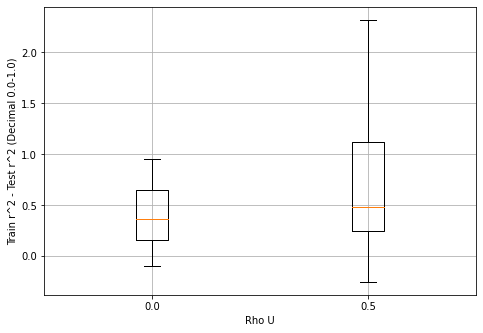

In [29]:
fig_bxplt_n, stats_n = fig_boxplot_r2differences(data_1_df, 'rho_U', title='Rho U', show_outliers=False)

In [30]:
def fig_boxplot_totaleffect(df, xvar, title='', show_outliers=False):
    differences_all = {}
    stats_all = {}
    for val in df[xvar].unique():
        differences = np.array(df.loc[df[xvar] == val]['r2_train'] - df.loc[df[xvar] == val]['totals_effect'])
        q1 = np.quantile(differences, 0.25)
        q3 = np.quantile(differences, 0.75)
        med = np.median(differences)
        upper_bound = q3 + (1.5*(q3-q1))
        lower_bound = q1 - (1.5*(q3-q1))

        differences_all[f'{xvar}_{str(val)}'] = differences
        outliers = sorted(differences[(differences <= lower_bound) | (upper_bound <= differences)])
        stats_all[f'{xvar}_{str(val)}'] = {'outliers': outliers, 'median':med, 'IQR':q3-q1}

    fig = plt.figure()
    axes = fig.add_axes([0,0,1,1])
    plt.boxplot(differences_all.values(), showfliers=show_outliers)
    k = len(df[xvar].unique())
    plt.xticks([i for i in range(1,k+1)],np.array(df[xvar].unique(), dtype=str))
    plt.grid()

    plt.xlabel(title)
    plt.ylabel("Train r^2 - Total Effect (Decimal 0.0-1.0)")
    
    return [fig, stats_all]



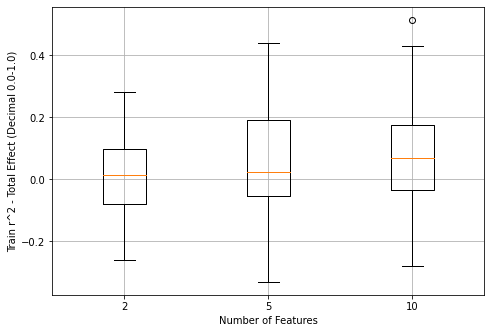

In [31]:
fig_bxplt_totaleffect, stats_totaleffect= fig_boxplot_totaleffect(data_1_df, 'features', title='Number of Features', show_outliers=True)

In [ ]:
# Test: saving matplotlib plots in pdfs
def fig_barh(ylabels, xvalues, title=''):
    # create a new figure
    fig = plt.figure()

    # plot to it
    yvalues = 0.1 + np.arange(len(ylabels))
    plt.barh(yvalues, xvalues, figure=fig)
    yvalues += 0.4
    plt.yticks(yvalues, ylabels, figure=fig)
    if title:
        plt.title(title, figure=fig)

    # return it
    return fig

def write_pdf(fname, figures):
    path = os.path.join(BASEPATH, 'main')
    doc = PdfPages(os.path.join(path, fname))
    for fig in figures:
        fig.savefig(doc, format='pdf')
    doc.close()

a = fig_barh(['a','b','c'], [1, 2, 3], 'Test #1')
b = fig_barh(['x','y','z'], [5, 3, 1], 'Test #2')
write_pdf('test.pdf', [a, b])

# Variable Importance

In [18]:
def fig_boxplot_vi(df, show_outliers=False): #  boxplot for 
    results = []
    stats_all = {}
    
    for var in ['cos_sim', 'cos_sim_rand']:
        vals = np.array(df[var])
        q1 = np.quantile(vals, 0.25)
        q3 = np.quantile(vals, 0.75)
        med = np.median(vals)
        upper_bound = q3 + (1.5*(q3-q1))
        lower_bound = q1 - (1.5*(q3-q1))

        outliers = sorted(vals[(vals <= lower_bound) | (upper_bound <= vals)])
        stats = {'outliers': outliers, 'median':med, 'IQR':q3-q1}
        
        results.append(vals)
        stats_all[var] = stats
    
    fig = plt.figure()
    axes = fig.add_axes([0,0,1,1])
    plt.boxplot(results, showfliers=show_outliers)
    plt.grid()
    plt.xticks([1,2], ["cos_sim", "cos_sim_rand"])
    plt.ylabel("Variable Imp. Measurement (-1.0 to 1.0)")
    
    return [fig, stats_all]


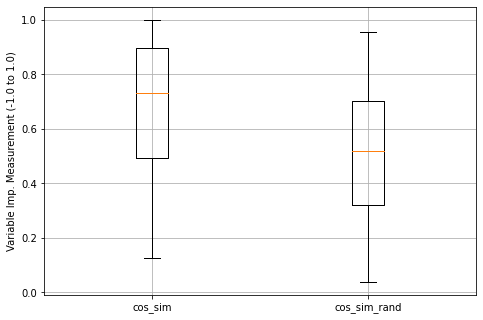

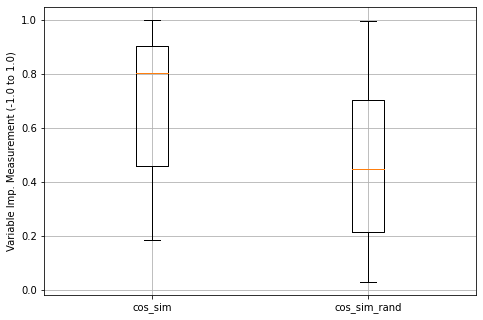

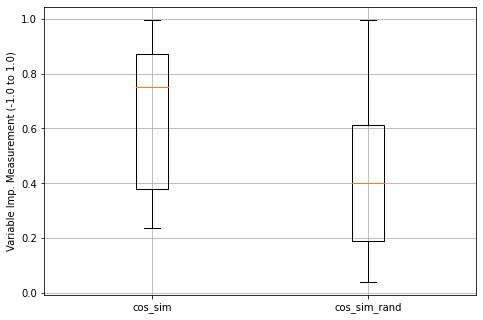

In [21]:
fig_bxplt_vi, stats_vi= fig_boxplot_vi(data_1_df.loc[data_1_df['N'] == 30], show_outliers=True)
fig_bxplt_vi, stats_vi= fig_boxplot_vi(data_1_df.loc[data_1_df['N'] == 50], show_outliers=True)
fig_bxplt_vi, stats_vi= fig_boxplot_vi(data_1_df.loc[data_1_df['N'] == 100], show_outliers=True)

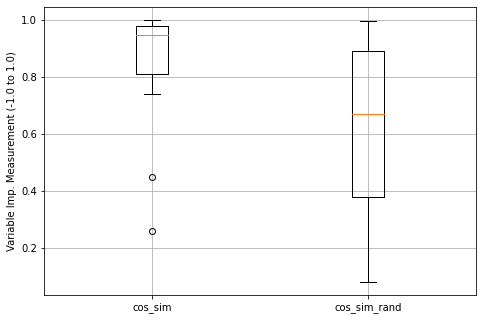

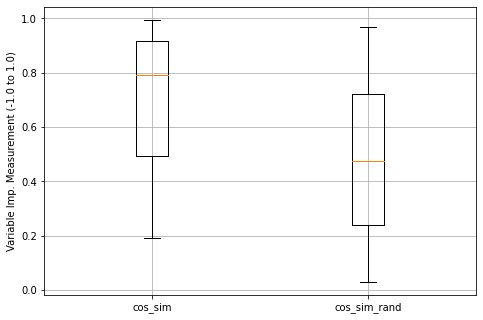

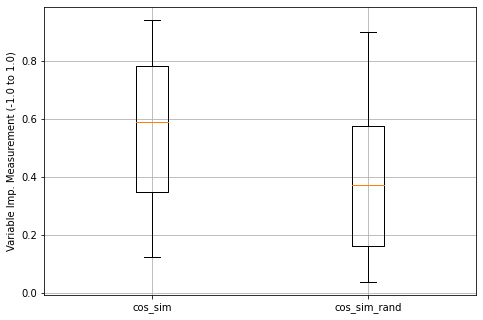

In [22]:
#data_1_df.to_csv('sim_results3.csv')

fig_bxplt_vi, stats_vi= fig_boxplot_vi(data_1_df.loc[data_1_df['features'] == 2], show_outliers=True)
fig_bxplt_vi, stats_vi= fig_boxplot_vi(data_1_df.loc[data_1_df['features'] == 5], show_outliers=True)
fig_bxplt_vi, stats_vi= fig_boxplot_vi(data_1_df.loc[data_1_df['features'] == 10], show_outliers=True)

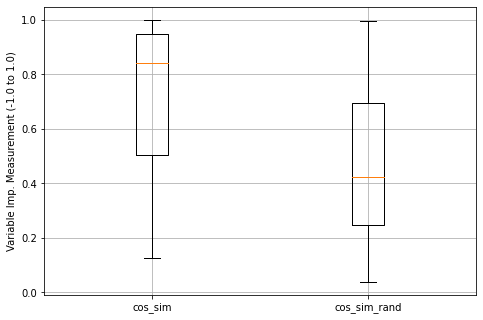

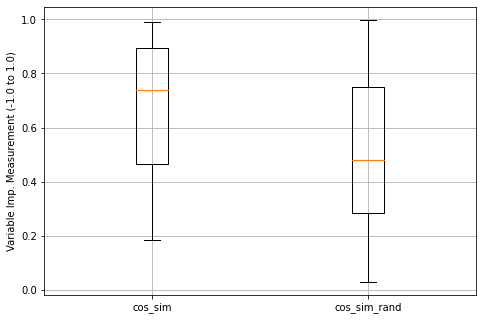

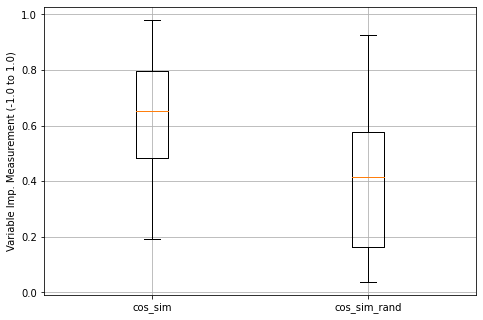

In [24]:
fig_bxplt_vi, stats_vi= fig_boxplot_vi(data_1_df.loc[data_1_df['nonlinear'] == 0], show_outliers=True)
fig_bxplt_vi, stats_vi= fig_boxplot_vi(data_1_df.loc[data_1_df['nonlinear'] == 1], show_outliers=True)
fig_bxplt_vi, stats_vi= fig_boxplot_vi(data_1_df.loc[data_1_df['nonlinear'] == 3], show_outliers=True)

In [ ]:
# Variable Importance Baseline Comparison

